In [8]:
import getpass
import os


In [9]:
from langchain_ollama import ChatOllama
local_llm = 'llama3.2'
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format='json')

In [10]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "dl-llama-project"

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [12]:
from database.pinecone_manager import PineconeManager
from config import API_KEY, INDEX_NAME
pinecone_manager = PineconeManager(API_KEY, INDEX_NAME)
pinecone_manager.initialize_index()

Index dlprojectcheck already exists
Index dlprojectcheck already exists


In [7]:
import os
import asyncio
import aiohttp
from bs4 import BeautifulSoup
from typing import List, Dict
from langchain.vectorstores import Pinecone
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter

class WebScraper:
    def __init__(self, session: aiohttp.ClientSession):
        self.session = session

    @staticmethod
    async def extract_sections(soup: BeautifulSoup) -> List[Dict[str, str]]:
        """Extracts sections from a parsed HTML page.

        Args:
            soup: A parsed HTML page.

        Returns:
            A list of dictionaries, where each dictionary contains the title and content of
            a section.
        """
        sections = []
        current_section = {"title": "Introduction", "content": "", "code": ""}

        for element in soup.find_all(['h1', 'h2', 'h3', 'p', 'pre']):
            if element.name in ['h1', 'h2', 'h3']:
                if current_section["content"] or current_section["code"]:
                    sections.append(current_section)
                current_section = {"title": element.get_text(strip=True), "content": "", "code": ""}
            elif element.name == 'p':
                current_section["content"] += element.get_text(strip=True) + "\n"
            elif element.name == 'pre':
                code = element.find('code')
                if code:
                    current_section["code"] += code.get_text(strip=True) + "\n\n"

        if current_section["content"] or current_section["code"]:
            sections.append(current_section)
            print("sections extracted returning sections ")

        return sections

    def create_documents(self, sections: List[Dict[str, str]]) -> List[Document]:
        """Convert scraped sections into LangChain Document objects."""
        documents = []
        for section in sections:
            content = section["content"]
            code = section["code"]
            combined_text = f"{content}\n\nCode:\n{code}"

            # Create a Document for each section with metadata
            document = Document(
                page_content=combined_text,
                metadata={"title": section["title"]}
            )
            documents.append(document)
            print("documents created returning document")
        return documents

    async def scrape_file(self, file_path: str) -> List[Document]:
        """Scrapes a single HTML file and returns a list of LangChain Document objects."""
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                html = file.read()
                soup = BeautifulSoup(html, 'html.parser')
                sections = await self.extract_sections(soup)

                documents = self.create_documents(sections)
                print("scraping and returning documents")
                return documents
        except Exception as e:
            print(f"Error scraping {file_path}: {str(e)}")
            return []

    async def scrape_files(self, file_paths: List[str]) -> List[Document]:
        """Scrape a list of local HTML files and return a list of LangChain Document objects."""
        tasks = [self.scrape_file(file_path) for file_path in file_paths]
        documents_list = await asyncio.gather(*tasks)

        # Flatten the list of document lists into a single list
        all_documents = [doc for sublist in documents_list for doc in sublist]
        return all_documents


In [8]:
import os
import aiohttp
import asyncio
from langchain.vectorstores import Pinecone
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.vectorstores import SKLearnVectorStore

# Prepare the list of file paths
html_files = []
dir_to_work_with = r'C:\\Users\\User\\OneDrive\\Desktop\\dl document loader\\keras website\\keras.io\\api'

for root, dirs, files in os.walk(dir_to_work_with):
    for file in files:
        if file.endswith(".html"):
            html_files.append(os.path.join(root, file))

# Scrape and store in vector store
async def main():
    async with aiohttp.ClientSession() as session:
        scraper = WebScraper(session)  # Assuming WebScraper is already defined and works
        documents = await scraper.scrape_files(html_files)

        # Initialize the Nomic embeddings
        nomic_embeddings = NomicEmbeddings(model="nomic-embed-text-v1.5",inference_mode='local')

        # Store documents in the SKLearnVectorStore
        vectorstore = SKLearnVectorStore.from_documents(
            documents=documents,
            embedding=nomic_embeddings
        )

        # Setup retriever to retrieve top 3 relevant documents
        retriever = vectorstore.as_retriever(k=3)

        # Return the retriever so it can be used outside
        return retriever

# Use `await` directly if you're in a running event loop environment
retriever = await main()

# Now you can use the `retriever` object from here
query = "How does Keras handle layers?"
results = retriever.get_relevant_documents(query)

for result in results:
    print(result)


sections extracted returning sections 
documents created returning document
documents created returning document
documents created returning document
documents created returning document
documents created returning document
documents created returning document
documents created returning document
scraping and returning documents
documents created returning document
documents created returning document
documents created returning document
scraping and returning documents
documents created returning document
scraping and returning documents
documents created returning document
scraping and returning documents
scraping and returning documents
documents created returning document
scraping and returning documents
documents created returning document
scraping and returning documents
documents created returning document
scraping and returning documents
documents created returning document
documents created returning document
scraping and returning documents
sections extracted returning sectio

In [12]:
#the new part with the FAISS index
import os
import asyncio
import aiohttp
from bs4 import BeautifulSoup
from typing import List, Dict
from langchain.docstore.document import Document
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

class WebScraper:
    def __init__(self, session: aiohttp.ClientSession):
        self.session = session

    @staticmethod
    async def extract_sections(soup: BeautifulSoup) -> List[Dict[str, str]]:
        sections = []
        current_section = {"title": "Introduction", "content": "", "code": ""}

        for element in soup.find_all(['h1', 'h2', 'h3', 'p', 'pre']):
            if element.name in ['h1', 'h2', 'h3']:
                if current_section["content"] or current_section["code"]:
                    sections.append(current_section)
                current_section = {"title": element.get_text(strip=True), "content": "", "code": ""}
            elif element.name == 'p':
                current_section["content"] += element.get_text(strip=True) + "\n"
            elif element.name == 'pre':
                code = element.find('code')
                if code:
                    current_section["code"] += code.get_text(strip=True) + "\n\n"

        if current_section["content"] or current_section["code"]:
            sections.append(current_section)

        return sections

    def create_documents(self, sections: List[Dict[str, str]], file_path: str) -> List[Document]:
        documents = []
        for section in sections:
            content = section["content"]
            code = section["code"]
            combined_text = f"{content}\n\nCode:\n{code}"

            document = Document(
                page_content=combined_text,
                metadata={
                    "title": section["title"],
                    "source": file_path
                }
            )
            documents.append(document)
        
        return documents

    async def scrape_file(self, file_path: str) -> List[Document]:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                html = file.read()
                soup = BeautifulSoup(html, 'html.parser')
                sections = await self.extract_sections(soup)

                documents = self.create_documents(sections, file_path)
                return documents
        except Exception as e:
            print(f"Error scraping {file_path}: {str(e)}")
            return []

    async def scrape_files(self, file_paths: List[str]) -> List[Document]:
        tasks = [self.scrape_file(file_path) for file_path in file_paths]
        documents_list = await asyncio.gather(*tasks)
        all_documents = [doc for sublist in documents_list for doc in sublist]
        return all_documents

async def main(dir_to_work_with: str, index_name: str):
    html_files = []
    for root, dirs, files in os.walk(dir_to_work_with):
        for file in files:
            if file.endswith(".html"):
                html_files.append(os.path.join(root, file))

    async with aiohttp.ClientSession() as session:
        scraper = WebScraper(session)
        documents = await scraper.scrape_files(html_files)

        embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

        if os.path.exists(f"{index_name}.faiss"):
            print("Loading existing FAISS index...")
            vectorstore = FAISS.load_local(index_name, embeddings)
            vectorstore.add_documents(documents)
        else:
            print("Creating new FAISS index...")
            vectorstore = FAISS.from_documents(documents, embeddings)

        vectorstore.save_local(index_name)

        retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

        return retriever

if __name__ == "__main__":
    dir_to_work_with = r'C:\Users\User\OneDrive\Desktop\dl document loader\keras website\keras.io\api'
    index_name = "keras_docs_index"

    retriever = await main(dir_to_work_with, index_name)

    query = "How does Keras handle layers?"
    results = retriever.get_relevant_documents(query)

    for result in results:
        print(f"Title: {result.metadata['title']}")
        print(f"Source: {result.metadata['source']}")
        print(f"Content: {result.page_content[:200]}...")
        print("-" * 50)

C:\Users\User\AppData\Local\Temp\ipykernel_3868\547668859.py:85: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_

Creating new FAISS index...
Title: Keras layers API
Source: C:\Users\User\OneDrive\Desktop\dl document loader\keras website\keras.io\api\layers.html
Content: Layers are the basic building blocks of neural networks in Keras.
A layer consists of a tensor-in tensor-out computation function (the layer'scallmethod)
and some state, held in TensorFlow variables (...
--------------------------------------------------
Title: Keras layers API
Source: C:\Users\User\OneDrive\Desktop\dl document loader\keras website\keras.io\api\layers\index.html
Content: Layers are the basic building blocks of neural networks in Keras.
A layer consists of a tensor-in tensor-out computation function (the layer'scallmethod)
and some state, held in TensorFlow variables (...
--------------------------------------------------
Title: Creating custom layers
Source: C:\Users\User\OneDrive\Desktop\dl document loader\keras website\keras.io\api\layers.html
Content: While Keras offers a wide range of built-in layers, they don

C:\Users\User\AppData\Local\Temp\ipykernel_3868\547668859.py:108: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = retriever.get_relevant_documents(query)


In [13]:
html_files = []
for root, dirs, files in os.walk(dir_to_work_with):
    for file in files:
        if file.endswith(".html"):
            html_files.append(os.path.join(root, file))
                
session = aiohttp.ClientSession
scraper = WebScraper(session)
documents = await scraper.scrape_files(html_files)

In [14]:
documents[0]

Document(metadata={'title': 'Keras Applications', 'source': 'C:\\Users\\User\\OneDrive\\Desktop\\dl document loader\\keras website\\keras.io\\api\\applications.html'}, page_content='Keras Applications are deep learning models that are made available alongside pre-trained weights.\nThese models can be used for prediction, feature extraction, and fine-tuning.\nWeights are downloaded automatically when instantiating a model. They are stored at~/.keras/models/.\nUpon instantiation, the models will be built according to the image data format set in your Keras configuration file at~/.keras/keras.json.\nFor instance, if you have setimage_data_format=channels_last,\nthen any model loaded from this repository will get built according to the TensorFlow data format convention, "Height-Width-Depth".\n\n\nCode:\n')

In [17]:
#retriveal grader->will see the question and the retrived and then give suggestion based on that
import json
from langchain.schema import SystemMessage, HumanMessage
### Retrieval Grader 

# Doc grader instructions 
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

# Test
question = "What are Keras Applications?"
docs = retriever.invoke(question)
doc_txt = documents[0].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(document=doc_txt, question=question)
result = llm_json_mode.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
json.loads(result.content)

{'binary_score': 'yes'}

In [20]:
### Generate

# Prompt
rag_prompt = """You are an intelligent assistant designed to provide accurate and relevant information from Keras documentation.

Here is the retrieved context, which may contain both explanatory text and meaningful code snippets:

{context}

Carefully analyze the above context, considering both the text and any provided code for clarity.

Now, review the user's query:

{question}

Generate a detailed response that accurately addresses the query using the provided context. If the context includes relevant code, incorporate it into your response. Ensure that your answer is both clear and grounded in the provided content.

Response:
"""

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Test
question = "How does Keras handle layers?"
docs = retriever.get_relevant_documents(question)
print(docs)
docs_txt = format_docs(docs)
print('formatted docs \n',docs_txt)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
print('rag format prompt \n',rag_prompt_formatted)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

[Document(metadata={'title': 'Keras layers API', 'source': 'C:\\Users\\User\\OneDrive\\Desktop\\dl document loader\\keras website\\keras.io\\api\\layers.html'}, page_content="Layers are the basic building blocks of neural networks in Keras.\nA layer consists of a tensor-in tensor-out computation function (the layer'scallmethod)\nand some state, held in TensorFlow variables (the layer'sweights).\nA Layer instance is callable, much like a function:\nUnlike a function, though, layers maintain a state, updated when the layer receives data\nduring training, and stored inlayer.weights:\n\n\nCode:\nfromtensorflow.kerasimportlayerslayer=layers.Dense(32,activation='relu')inputs=tf.random.uniform(shape=(10,20))outputs=layer(inputs)\n\n>>>layer.weights[<tf.Variable'dense/kernel:0'shape=(20,32)dtype=float32>,<tf.Variable'dense/bias:0'shape=(32,)dtype=float32>]\n\n"), Document(metadata={'title': 'Keras layers API', 'source': 'C:\\Users\\User\\OneDrive\\Desktop\\dl document loader\\keras website\\ke

KeyboardInterrupt: 

In [23]:
### Hallucination Grader 

# Hallucination grader instructions 
hallucination_grader_instructions = """

You are a grader evaluating the quality of a response generated by an assistant based on Keras documentation.

You will be given CONTEXT from the Keras documentation and the ASSISTANT'S RESPONSE.

Here are the grading criteria to follow:

(1) Ensure the ASSISTANT'S RESPONSE is fully grounded in the CONTEXT provided.

(2) Ensure the ASSISTANT'S RESPONSE does not contain any information outside the scope of the CONTEXT or hallucinated details.

Score:

A score of "yes" means the response is fully grounded in the CONTEXT and does not introduce hallucinated information. This is the best score.

A score of "no" means the response is not fully grounded in the CONTEXT or includes hallucinated information. This is the lowest score.

In your feedback, explain your reasoning in a detailed, step-by-step manner to ensure that your conclusion is well-supported. Avoid jumping to conclusions without clear justification from the CONTEXT.
"""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""

# Test using documents and generation from above 
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=docs_txt, generation=generation.content)
result = llm_json_mode.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': 'The STUDENT ANSWER meets all the criteria set by the FACTS.\n\n',
 "It correctly states that Keras handles layers as basic building blocks of neural networks, consisting of a tensor-in tensor-out computation function (the layer's call method) and state held in TensorFlow variables (the layer's weights).\n\n": 'The STUDENT ANSWER also accurately describes the behavior of Layer instances, stating they are callable like a function but maintain state updated during training.\n\n',
 'Furthermore, the STUDENT ANSWER correctly mentions that Keras offers a wide range of built-in layers and provides an easy way to create custom layers via subclassing the base Layer class.\n\n': 'The only minor issue is that the STUDENT ANSWER does not explicitly mention the importance of weights in maintaining state during training, but this is a minor point and overall the answer is accurate and comprehensive.'}

In [25]:
### Answer Grader 

# Answer grader instructions 
answer_grader_instructions = """You are a grader evaluating the quality of a response generated by an assistant based on a user's query related to Keras documentation.

You will be given a USER QUESTION and the ASSISTANT'S RESPONSE.

Here are the grading criteria to follow:

(1) The ASSISTANT'S RESPONSE should accurately address the USER QUESTION and provide relevant information based on the context.

Score:

A score of "yes" means the response effectively addresses the USER QUESTION and provides a clear and relevant answer. This is the best score.

The assistant can receive a score of "yes" even if the response includes additional, helpful information beyond what was explicitly asked.

A score of "no" means the response does not adequately address the USER QUESTION or is incomplete.

In your feedback, explain your reasoning in a clear, step-by-step manner to justify your conclusion. Avoid simply stating the correct answer without explanation.
"""

# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""

# Test
question = "How does Keras handle layers?"
answer = "Keras handles layers as basic building blocks of neural networks, consisting of a tensor-in tensor-out computation function (the layer's call method) and state held in TensorFlow variables (the layer's weights). A Layer instance is callable like a function but maintains state updated during training. Keras offers a wide range of built-in layers, but custom layers can be easily created via subclassing the base Layer class."

# Test using question and generation from above 
answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation)
result = llm_json_mode.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': "The student's answer meets all the criteria for answering the question about how Keras handles layers. They correctly describe the basic building blocks of neural networks in Keras, including the layer's call method and state held in TensorFlow variables. Additionally, they mention that Keras offers a wide range of built-in layers and provide information on how to create custom layers via subclassing the base Layer class. The answer is clear, concise, and accurate."}

In [2]:
#creating the state for our application part
import operator
from typing_extensions import TypedDict
from typing import List, Annotated

class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """
    question : str # User question
    generation : str # LLM generation
    max_retries : int # Max number of retries for answer generation
    answers : int # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents : List[str] # List of retrieved documents

In [3]:
from langchain.schema import Document
from langgraph.graph import END

### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step+1}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(document=d.page_content, question=question)
        result = llm_json_mode.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
        grade = json.loads(result.content)['binary_score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            continue
    return {"documents": filtered_docs}
    
# def web_search(state):
#     """
#     Web search based based on the question

#     Args:
#         state (dict): The current graph state

#     Returns:
#         state (dict): Appended web results to documents
#     """

#     print("---WEB SEARCH---")
#     question = state["question"]
#     documents = state.get("documents", [])

#     # Web search
#     docs = web_search_tool.invoke({"query": question})
#     web_results = "\n".join([d["content"] for d in docs])
#     web_results = Document(page_content=web_results)
#     documents.append(web_results)
#     return {"documents": documents}


### Edges

# def route_question(state):
#     """
#     Route question to web search or RAG 

#     Args:
#         state (dict): The current graph state

#     Returns:
#         str: Next node to call
#     """

#     print("---ROUTE QUESTION---")
#     route_question = llm_json_mode.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=state["question"])])
#     source = json.loads(route_question.content)['datasource']
#     if source == 'websearch':
#         print("---ROUTE QUESTION TO WEB SEARCH---")
#         return "websearch"
#     elif source == 'vectorstore':
#         print("---ROUTE QUESTION TO RAG---")
#         return "vectorstore"

# def decide_to_generate(state):
#     """
#     Determines whether to generate an answer, or add web search

#     Args:
#         state (dict): The current graph state

#     Returns:
#         str: Binary decision for next node to call
#     """

#     print("---ASSESS GRADED DOCUMENTS---")
#     question = state["question"]
#     web_search = state["web_search"]
#     filtered_documents = state["documents"]

#     if web_search == "Yes":
#         # All documents have been filtered check_relevance
#         # We will re-generate a new query
#         print("---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
#         return "websearch"
#     else:
#         # We have relevant documents, so generate answer
#         print("---DECISION: GENERATE---")
#         return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3) # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=format_docs(documents), generation=generation.content)
    result = llm_json_mode.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
    grade = json.loads(result.content)['binary_score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above 
        answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation.content)
        result = llm_json_mode.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
        grade = json.loads(result.content)['binary_score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

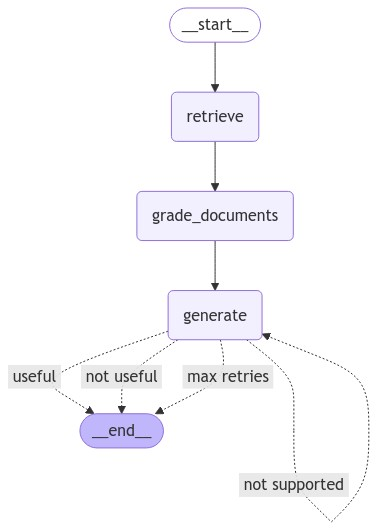

In [6]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
# workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate

workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve","grade_documents")
workflow.add_edge("grade_documents","generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": END,
        "max retries": END,
    },
)
# # Build graph
# workflow.set_conditional_entry_point(
#     route_question,
#     {
#         "websearch": "websearch",
#         "vectorstore": "retrieve",
#     },
# )
# workflow.add_edge("websearch", "generate")
# workflow.add_edge("retrieve", "grade_documents")
# workflow.add_conditional_edges(
#     "grade_documents",
#     decide_to_generate,
#     {
#         "websearch": "websearch",
#         "generate": "generate",
#     },
# )
# workflow.add_conditional_edges(
#     "generate",
#     grade_generation_v_documents_and_question,
#     {
#         "not supported": "generate",
#         "useful": END,
#         "not useful": "websearch",
#         "max retries": END,
#     },
# )

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
inputs = {"question": "How does Keras handle layers?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

{'question': 'How does Keras handle layers?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---


NameError: name 'retriever' is not defined